# Python for Finance - part 1

#### 금융분석과 관련된 기본적인 내용을 정리하였습니다. 파이썬을 활용한 금융분석 (이브 힐피시 지음)을 참고하였습니다.

## Chapter 3. 입문용 예제
#### 내재 변동성 : 옵션의 호가로부터 옵션의 내재 변동성을 구하고 만기일과 행사가에 따른 그래프를 그려본다.
#### 몬테카를로 시뮬레이션 : 주가지수가 시간에 따라 변화하는 것을 시물레이션하고 일부 결과를 시각화, 주가지수에 따른 유러피안 옵션 가치도 계산
#### 기술적 분석 : 추세 신호에 기반한 투자 전략을 백테스트하기 위해 시계열 자료 분석 작업을 구현

### 3.1 내재 변동성 계산
#### 내재 변동성 : 옵션의 시장 가격을 나오게 하는 변동성 값 -> 수치 최적화 문제
#### 블랙-숄즈-머튼 모형 : 옵션 가격 계산 공식, 변동성 값을 입력하여 옵션의 값을 계산
#### 변동성 옵션 : VSTOXX 변동성 지수가 기초자산

In [24]:
#### 블랙-숄즈-머튼 모형을 사용한 유러피안 콜 옵션 가격 결정
#### 베가 계산 함수와 내재 변동성 추정 함수를 포함

def bsm_call_value(S0:float, K:float, T:float, r:float, sigma:float) -> float:
    '''
    블랙-숄즈-머튼 모형을 사용한 유러피안 콜 옵션 가격결정 공식
    
    :param S0: 초기 주가 혹은 지수
    :param K: 행사가
    :param T: 만기까지 남은 시간(연 단위)
    :param r: 고정 무위험 단기 이자율
    :param sigma: 변동성 파라미터
    
    :return: 유러피안 콜 옵션의 현재가격
    '''
    
    from math import log, sqrt, exp
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma **2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma **2) * T) / (sigma * sqrt(T))
    value = (S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * stats.norm.cdf(d2, 0., 1.))
    
    return value

def bsm_vega(S0:float, K:float, T:float, r:float, sigma:float) -> float:
    '''
    블랙-숄즈-머튼 모형을 사용한 유러피안 콜 옵션의 베가 계산
    
    :param S0: 초기 주가 혹은 지수
    :param K: 행사가
    :param T: 만기까지 남은 시간(연 단위)
    :param r: 고정 무위험 단기 이자율
    :param sigma: 변동성 파라미터
    
    :return: 블랙-숄즈-머튼 공식을 변동성에 대해 1차 미분한 값, 베가
    '''
    
    from math import log, sqrt, exp
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma **2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.cdf(d1, 0., 1.) * sqrt(T)
    return vega

def bsm_call_imp_vol(S0:float, K:float, T:float, r:float, C0: float, sigma_est:float, it:int =100) -> float:
    '''
    블랙-숄즈-머튼 모형을 사용한 유러피안 옵션의 내재 변동성 계산
    
    :param S0: 초기 주가 혹은 지수
    :param K: 행사가
    :param T: 만기까지 남은 시간(연 단위)
    :param r: 고정 무위험 단기 이자율
    :param sigma_est: 변동성 파라미터 초기 추정치
    :param it : 반복 계산 횟수
    
    :return: 수치적으로 추정한 내재 변동성
    '''
    
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0) / bsm_vega(S0, K, T, r, sigma_est))
        return sigma_est

In [18]:
V0 = 17.6639 #### 2014-03-31 시점의 VSTOXX 지수 종가
r = .01

import pandas as pd
import datetime as dt
h5 = pd.HDFStore('./source/vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data']
options_data = h5['options_data']
h5.close()

# futures_data['DATE'] = futures_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
# futures_data['MATURITY'] = futures_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
# options_data['DATE'] = options_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
# options_data['MATURITY'] = options_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [19]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31,2014,4,17.85,2014-04-18,0.049
497,2014-03-31,2014,5,19.55,2014-05-16,0.126
498,2014-03-31,2014,6,19.95,2014-06-20,0.222
499,2014-03-31,2014,7,20.40,2014-07-18,0.299
500,2014-03-31,2014,8,20.70,2014-08-15,0.375
501,2014-03-31,2014,9,20.95,2014-09-19,0.471
502,2014-03-31,2014,10,21.05,2014-10-17,0.548
503,2014-03-31,2014,11,21.25,2014-11-21,0.644


In [20]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       395 non-null    datetime64[ns]
 1   EXP_YEAR   395 non-null    int64         
 2   EXP_MONTH  395 non-null    int64         
 3   TYPE       395 non-null    object        
 4   STRIKE     395 non-null    float64       
 5   PRICE      395 non-null    float64       
 6   MATURITY   395 non-null    datetime64[ns]
 7   TTM        395 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [21]:
options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head()

,DATE,MATURITY,TTM,STRIKE,PRICE
46170,2014-03-31,2014-04-18,0.049,1.0,16.85
46171,2014-03-31,2014-04-18,0.049,2.0,15.85
46172,2014-03-31,2014-04-18,0.049,3.0,14.85
46173,2014-03-31,2014-04-18,0.049,4.0,13.85
46174,2014-03-31,2014-04-18,0.049,5.0,12.85


In [27]:
options_data['IMP_VOL'] = 0.

tol = .5
for option in options_data.index:
    # iterating over all option quotes
    forward = futures_data[futures_data['MATURITY'] == \
                options_data.loc[option]['MATURITY']]['PRICE'].values[0]
      # picking the right futures value
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE']
                             < forward * (1 + tol)):
        imp_vol = bsm_call_imp_vol(V0, options_data.loc[option]['STRIKE'], options_data.loc[option]['TTM'], r,
                                  options_data.loc[option]['PRICE'], 2., 100)
        options_data['IMP_VOL'].loc[option] = imp_vol

/Users/qook/Python/3.7/venv/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [30]:
plot_data = options_data[options_data['IMP_VOL'] > 0]
maturities = sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

/Users/qook/Python/3.7/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/qook/Python/3.7/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/qook/Python/3.7/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/qook/Python/3.7/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/qook/Python/3.7/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/qook/Pyt

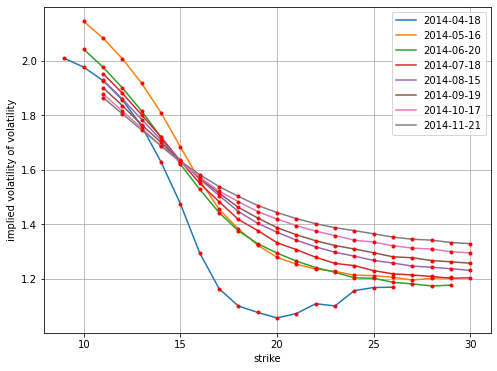

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
    plt.plot(data['STRIKE'], data['IMP_VOL'], label=maturity.date(), lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()

### 3.2 몬테카를로 시뮬레이션
#### 계산량이나 복잡도가 차원에 따라 선형적으로 증가하기 때문에 고차원 문제를 쉽게 풀 수 있음
#### 아주 쉬운 문제를 푸는 데에도 계산량이 많고 메모리를 많이 요구한다는 단점 존재

#### 3.2.1 순수 파이썬 구현

In [39]:
#### 파이썬만으로 구현한 유러피안 콜 옵션의 몬테카를로 가격 계산

from time import time
from math import exp, sqrt, log
from random import gauss, seed

seed(2000)
t0 = time()

# 인수
S0 = 100.
K = 105.
T = 1.
r = .05
sigma = .2
M = 50 #### 시간 구간 개수
dt  = T / M #### 하나의 시간 구간의 길이
I = 250000 #### 샘플 경로의 수

#### 경로 하나당 M개의 시간 구간을 가지는 I개의 샘플 경로를 생성
S = []
for i in range(I):
    path = []
    for t in range(M+1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0., 1.)
            St = path[t-1] * exp((r-.5 * sigma ** 2) * dt + sigma * sqrt(dt) * z)
            path.append(St)
    S.append(path)
    
#### 몬테카를로 방법을 사용한 가격 추정
C0 = exp(-r * T) * sum([max(path[-1] - K, 0) for path in S]) / I

tpy = time() - t0
print('European Option Value %7.3f' % C0)
print('Duration in Seconds %7.3f' % tpy)

European Option Value   8.011
Duration in Seconds  13.023


#### 3.2.2 Numpy를 이용한 벡터화

In [41]:
#### Numpy로 구현한 유러피안 콜 옵션의 몬테카를로 가격 계산

import math
import numpy as np
from time import time

np.random.seed(2000)
t0 = time()

# 인수
S0 = 100.
K = 105.
T = 1.
r = .05
sigma = .2
M = 50 #### 시간 구간 개수
dt  = T / M #### 하나의 시간 구간의 길이
I = 250000 #### 샘플 경로의 수

#### 경로 하나당 M개의 시간 구간을 가지는 I개의 샘플 경로를 생성
S = np.zeros((M+1, I))
S[0] = S0
for t in range(1, M+1):
    z = np.random.standard_normal(I)
    S[t] = S[t-1] * np.exp((r-0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * z)
    
C0 = math.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I

tnp1 = time() - t0
print('European Option Value %7.3f' % C0)
print('Duration in Seconds %7.3f' % tnp1)

European Option Value   8.018
Duration in Seconds   0.490


#### 3.2.3 로그-오일러 이산화를 적용한 벡터화

In [42]:
#### Numpy로 구현한 유러피안 콜 옵션의 몬테카를로 가격 계산(로그 버전)

import math
from numpy import *
from time import time

np.random.seed(2000)
t0 = time()

# 인수
S0 = 100.
K = 105.
T = 1.
r = .05
sigma = .2
M = 50 #### 시간 구간 개수
dt  = T / M #### 하나의 시간 구간의 길이
I = 250000 #### 샘플 경로의 수

#### 경로 하나당 M개의 시간 구간을 가지는 I개의 샘플 경로를 생성
S = S0 * exp(cumsum((r-.5 * sigma ** 2) *dt + sigma * math.sqrt(dt) * random.standard_normal((M+1, I)), axis=0))
S[0] = S0
C0 = math.exp(-r * T) * sum(maximum(S[-1] - K, 0)) / I

tnp2 = time() - t0
print('European Option Value %7.3f' % C0)
print('Duration in Seconds %7.3f' % tnp2)

European Option Value   8.145
Duration in Seconds   0.568


#### 3.2.4 시각적 분석

Text(0, 0.5, 'index level')

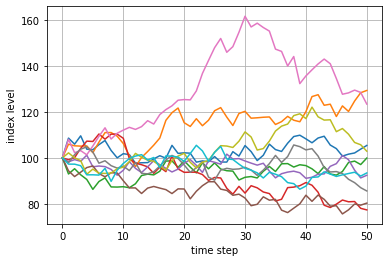

In [43]:
import matplotlib.pyplot as plt
plt.plot(S[:, :10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')

Text(0, 0.5, 'frequency')

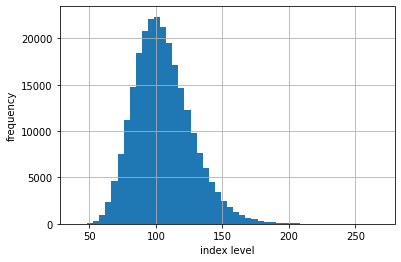

In [44]:
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')

(0.0, 50000.0)

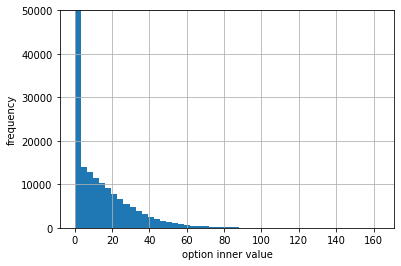

In [45]:
plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0, 50000)

### 3.3 기술적 분석
#### 미래의 주가 움직임을 예측하기보다는 백테스트 목적으로 과거 시장 정보를 분석하는데 초점을 맞춤

In [55]:
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as web

yf.pdr_override()
SPY = web.get_data_yahoo('SPY', start = '2000-01-01', end = '2014-04-14')
SPY.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3591 entries, 2000-01-03 00:00:00-05:00 to 2014-04-11 00:00:00-04:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3591 non-null   float64
 1   High       3591 non-null   float64
 2   Low        3591 non-null   float64
 3   Close      3591 non-null   float64
 4   Adj Close  3591 non-null   float64
 5   Volume     3591 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 325.4 KB


In [58]:
SPY['42d'] = np.round(SPY['Close'].rolling(window=42).mean(), 2)
SPY['252d'] = np.round(SPY['Close'].rolling(window=252).mean(), 2)
SPY[['Close', '42d', '252d']].tail()

,Close,42d,252d
Date,,,
2014-04-07 00:00:00-04:00,184.339996,185.34,172.86
2014-04-08 00:00:00-04:00,185.100006,185.52,172.97
2014-04-09 00:00:00-04:00,187.089996,185.70,173.08
2014-04-10 00:00:00-04:00,183.160004,185.77,173.18
2014-04-11 00:00:00-04:00,181.509995,185.76,173.27
